<a href="https://colab.research.google.com/github/Kouichi1229/Python_work/blob/main/CAM_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3 # 這裡改其他模組
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow 

In [ ]:
model = InceptionV3(weights='imagenet') # 改

model.summary()

96116736/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________

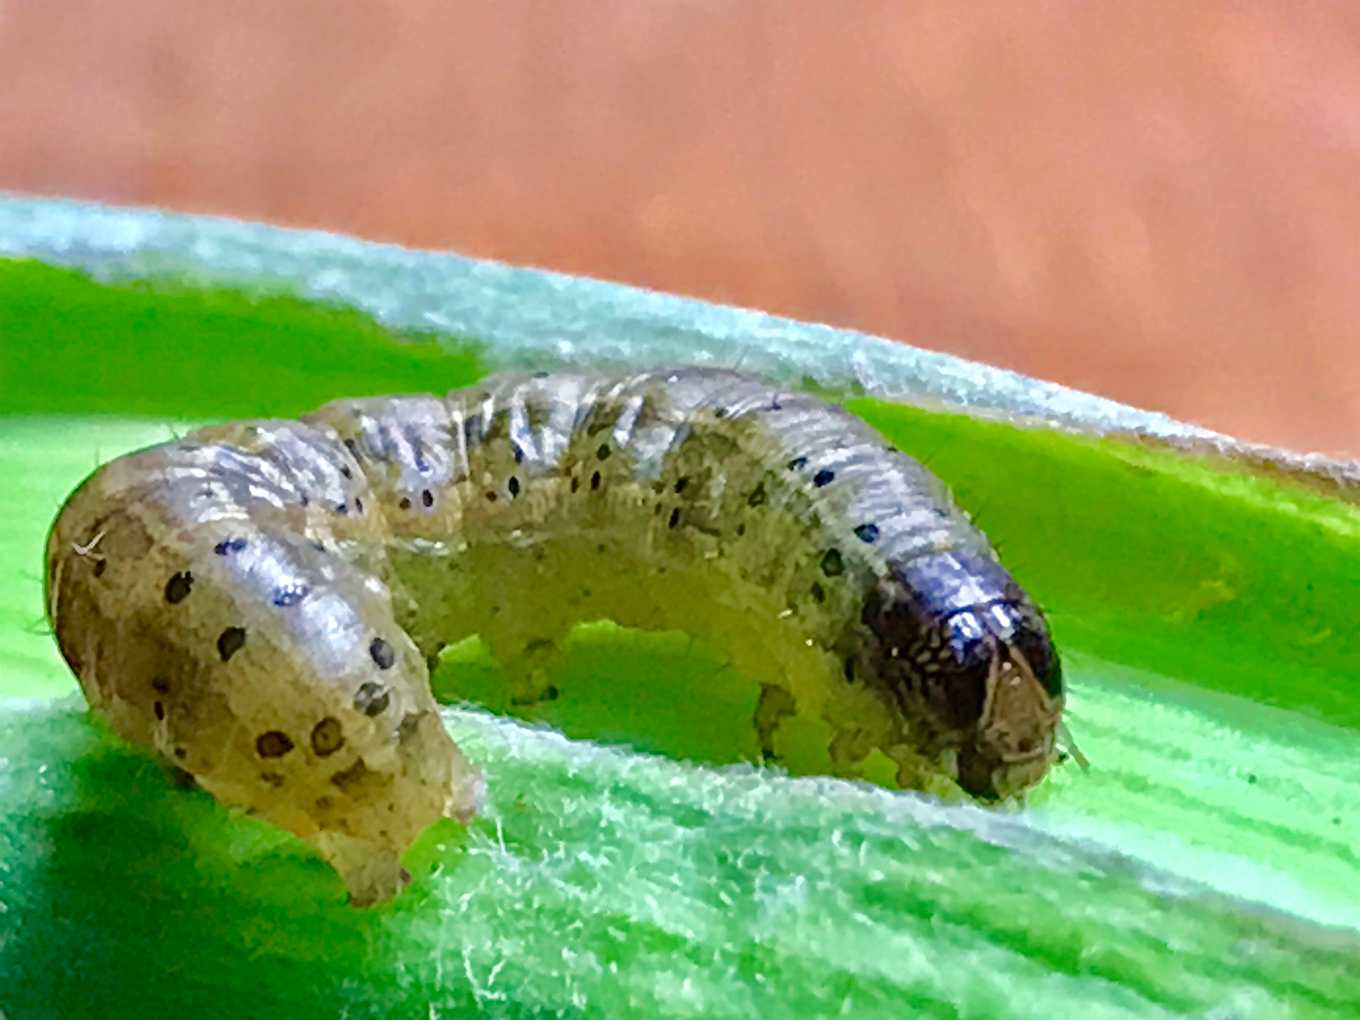

In [ ]:
ORIGINAL = '01.jpg'

DIM = 299 # file input_shape(299,299,3)

img = image.load_img(ORIGINAL, target_size=(DIM, DIM))

cv2_imshow(cv2.imread(ORIGINAL))

In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print(decode_predictions(preds))

40960/35363 [==================================] - 0s 0us/step
[[('n01784675', 'centipede', 0.17278762), ('n01990800', 'isopod', 0.15178145), ('n01728572', 'thunder_snake', 0.049435157), ('n02169497', 'leaf_beetle', 0.040225275), ('n02219486', 'ant', 0.022763656)]]




```
[[('n01784675', 'centipede', 0.17278762), ('n01990800', 'isopod', 0.15178145), ('n01728572', 'thunder_snake', 0.049435157), ('n02169497', 'leaf_beetle', 0.040225275), ('n02219486', 'ant', 0.022763656)]]
```
這裡是原本模組裡文件有的label_index 還沒+入自己的 label 被標記的總類


In [ ]:
with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('conv2d_93')
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(x)
  class_out = model_out[:, np.argmax(model_out[0])]
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

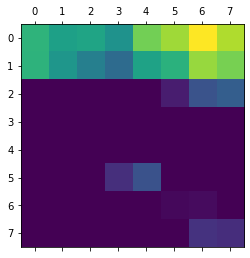

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((8, 8))
plt.matshow(heatmap)
plt.show()

In [ ]:
img = cv2.imread(ORIGINAL)

In [ ]:
INTENSITY = 0.5

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

img = heatmap * INTENSITY + img

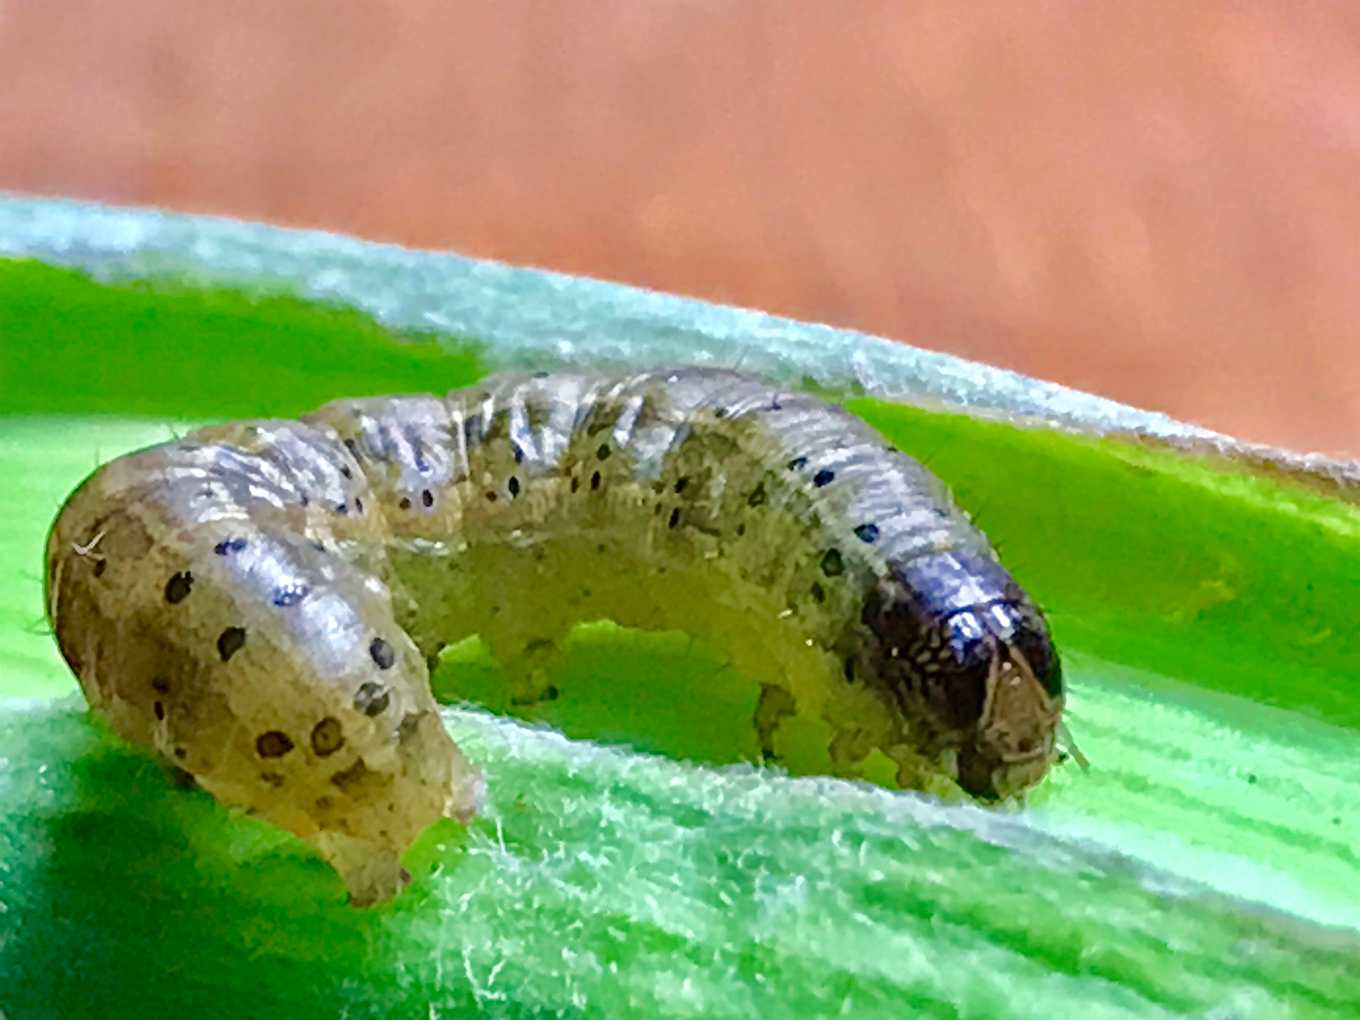

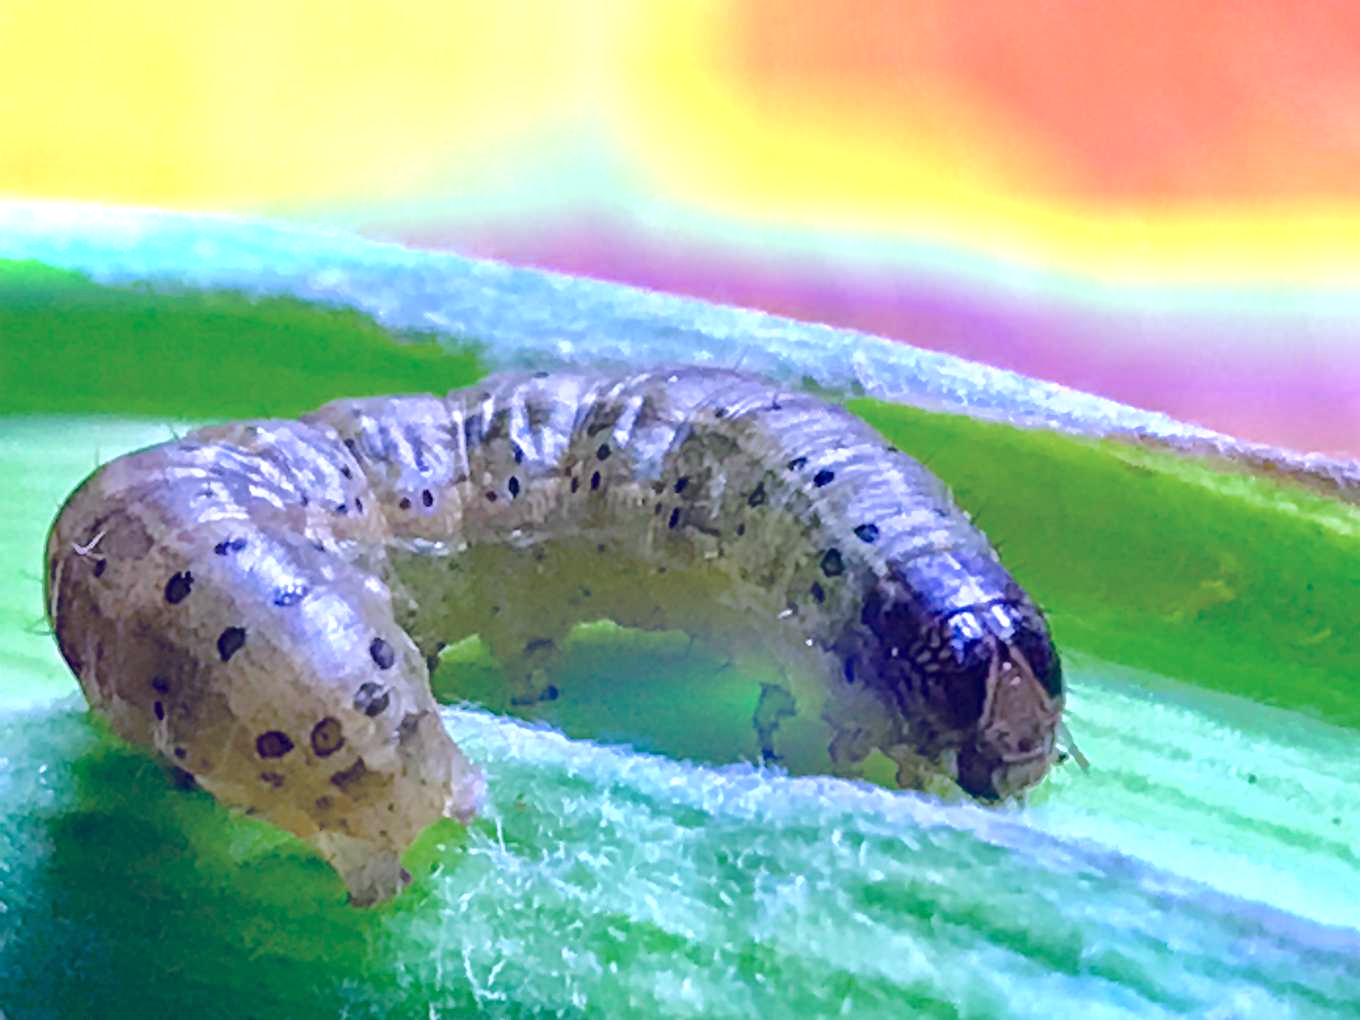

In [ ]:
cv2_imshow(cv2.imread(ORIGINAL))
cv2_imshow(img)

In [ ]:
def gradCAM(orig, intensity=0.5, res=250):
  img = image.load_img(orig, target_size=(DIM, DIM))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  print(decode_predictions(preds)[0][0][1]) # prints the class of image

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv2d_93')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((8, 8))

  img = cv2.imread(orig)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

  img = heatmap * intensity + img

  cv2_imshow(cv2.resize(cv2.imread(orig), (res, res)))
  cv2_imshow(cv2.resize(img, (res, res)))

acorn


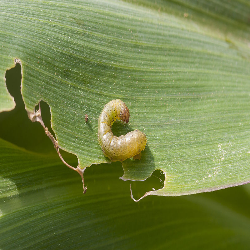

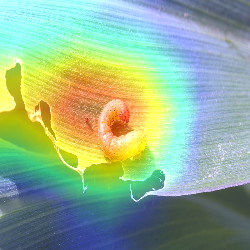

In [ ]:
gradCAM('02.jpg')